In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


**Description of Project**

"The goal of this project is to predict whether a client will subscribe to a term deposit, using data on client demographics, interactions, and campaign details."

**Columns Description**
- last contact date: Date of last client contact
- age: Client's age (numeric)
- job: Client's job type
- marital: Marital status ("married", "divorced", "single")
- education: Education level ("primary", "secondary", "tertiary","unknown")
- default: Credit in default? ("yes", "no")
- balance: Average yearly balance (€)
- housing: Housing loan? ("yes", "no")
- loan: Personal loan? ("yes", "no")
- contact: Communication type ("cellular", "telephone")
- duration: Last contact duration (sec)
- campaign: Number of contacts performed  in this campaign
- pdays: Days since last contact (-1 = no contact)
- previous: Number of Contacts performed before this campaign
- poutcome: Previous campaign result ("success", "failure","other","unknown")
- target: has the client subscribed a term deposit? (binary: "yes","no")( this is our target variable)

**Importing Libraries**

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Setup
import warnings
from scipy.stats import skew

#Scikit-learn Tools
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

#Train-Test Splitting
from sklearn.model_selection import train_test_split

#Column Transformer
from sklearn.compose import ColumnTransformer

#Dimensionality Reduction
from sklearn.decomposition import PCA

#Model Evaluation Metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Hyperparamater Tuning
from sklearn.model_selection import GridSearchCV

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

**Reading the Data**

In [4]:
train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

## EDA (Exploratory Data Analysis) ##

**Univariate analysis**
- Visualize the distribution of individual features

**Multivariate analysis**
- Analyze relationship b/w features & the target
- Correlation to explore relationship b/w numerical variables
- Examine the distribution of target across categorical variables

## 1. Data Overview ##

**Check Dataset Dimesions**

In [5]:
print("Shape of Train Dataset :",train.shape)
print("Shape of Test Dataset :" ,test.shape)

Shape of Train Dataset : (39211, 16)
Shape of Test Dataset : (10000, 15)


**Data Preview**

In [6]:
train.head().T

,0,1,2,3,4
last contact date,2009-04-17,2009-10-11,2010-11-20,2009-09-01,2008-01-29
age,26,52,44,33,31
job,blue-collar,technician,blue-collar,admin.,entrepreneur
marital,married,married,married,married,single
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,647,553,1397,394,137
housing,yes,yes,no,yes,no
loan,no,no,no,no,no
contact,cellular,telephone,cellular,telephone,cellular


**Get Column Information**

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

**Category of Columns**

In [8]:
cat = train.select_dtypes(include=['object']).columns.tolist()
num = train.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical Columns: ", cat)
print("Numerical Columns: ", num)

Categorical Columns:  ['last contact date', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'target']
Numerical Columns:  ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


**Unique values**

In [9]:
cols = []
for i in train.columns:
    print(f"{i} : {train[i].nunique()}")
    if train[i].nunique()<=15:
        cols.append(i)

last contact date : 1013
age : 78
job : 11
marital : 3
education : 3
default : 2
balance : 9535
housing : 2
loan : 2
contact : 2
duration : 3146
campaign : 63
pdays : 865
previous : 276
poutcome : 3
target : 2


**Summary statistics**

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,39211.0,42.120247,12.709352,18.0,33.0,40.0,50.0,95.0
balance,39211.0,5441.781719,16365.292065,-8019.0,98.0,549.0,2030.0,102127.0
duration,39211.0,439.062789,769.096291,0.0,109.0,197.0,380.0,4918.0
campaign,39211.0,5.108770,9.890153,1.0,1.0,2.0,4.0,63.0
pdays,39211.0,72.256051,160.942593,-1.0,-1.0,-1.0,-1.0,871.0
previous,39211.0,11.826171,44.140259,0.0,0.0,0.0,0.0,275.0



#### 1. age (Age of clients):
* Range: Values range from 18 to 95 years.
* Mean: The average age of clients is 42.12 years.
* Standard Deviation: Relatively low at 12.71, indicating a clustered distribution around the mean.
* Insight: Clients are primarily middle-aged, but the range suggests diversity in age groups.

#### 2. balance (Average yearly balance in euros):
* Range: -€8,019 to €102,127, with negative balances indicating debts.
* Mean: €5,441.78, but the high standard deviation of €16,365.29 suggests large variability.
* Insight: Presence of extreme outliers and negative balances highlights the need for capping.

#### 3. duration (Duration of last contact in seconds):
* Range: 0 to 4,918 seconds (~82 minutes).
* Mean: 439 seconds (~7.3 minutes), with high variability (std: 769 seconds).
* Insight: A strong predictor of the target variable

#### 4. campaign (Number of contacts during this campaign):
* Range: 1 to 63 contacts, with a mean of 5.1 contacts and a high standard deviation of 9.89.
* Insight: Extremely high values (e.g., 63 contacts) indicate possible over-contacting, which might negatively affect campaign performance.

#### 5. pdays (Number of days since the client was last contacted in a previous campaign):
* Range: -1 to 871 days, where -1 represents no prior contact.
* Mean: 72.26 days, but the prevalence of -1 is high (observed in the 25th, 50th, and 75th percentiles).

#### 6. previous (Number of contacts performed before this campaign):
* Range: 0 to 275, with a mean of 11.83 contacts and a high standard deviation of 44.14.
* Insight: The median is 0, indicating that most clients were not contacted previously. High variability suggests the presence of outliers, which may require capping or grouping into bins.

## 2. Missing Values ##

**Check Missing Values**

In [11]:
print(train.isnull().sum())

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64


**Observation**: Columns has missing values:
- job: 229 missing (~0.58%)
- education: 1467 missing (~3.74%)
- contact: 10336 missing (~26.36%)
- poutcome: 29451 missing (~75.11%)

**Missing Value Overview**:
- Columns with fewer missing values ("job", "education") are manageable via imputation exclusion.
- Columns with higher mssing rates ("contact", "poutcome") might require seperate encoding or exclusion.

**Visualize Missing Data**

<Axes: >

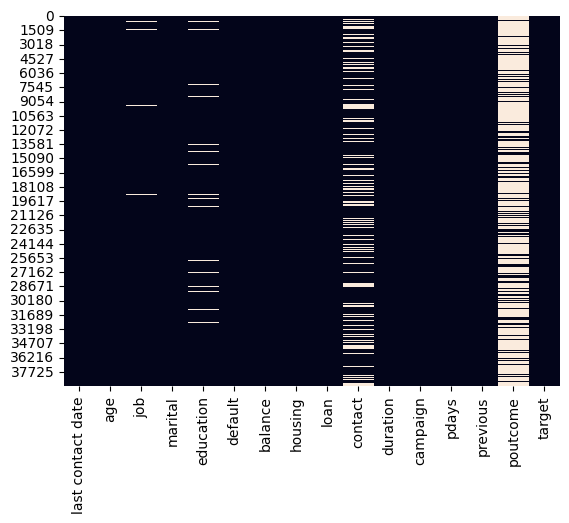

In [12]:
sns.heatmap(train.isnull(), cbar=False)

## 3. Target Variable Analysis ##

target
no     33384
yes     5827
Name: count, dtype: int64


<Axes: xlabel='target', ylabel='count'>

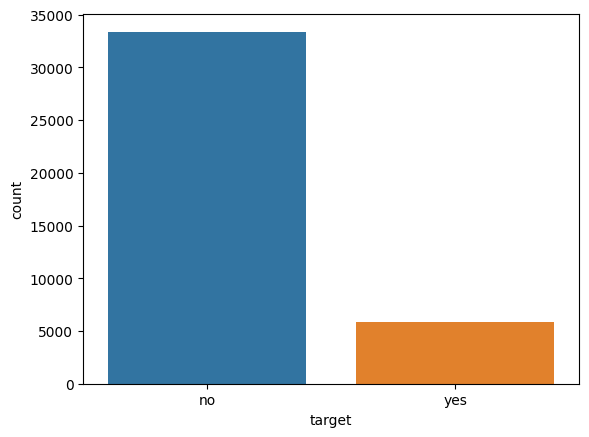

In [13]:
print(train['target'].value_counts())
sns.countplot(x='target', data=train)

"The target variable is **imbalanced**, with 33,384 'no' and only 5,827 'yes'. This highlights the **need to address class imbalance during modeling**."

**Encode Target variable**

In [14]:
train['target']=train['target'].map({'yes': 1, 'no': 0})

## 4. Univariate Analysis ##

**Categorical Features**

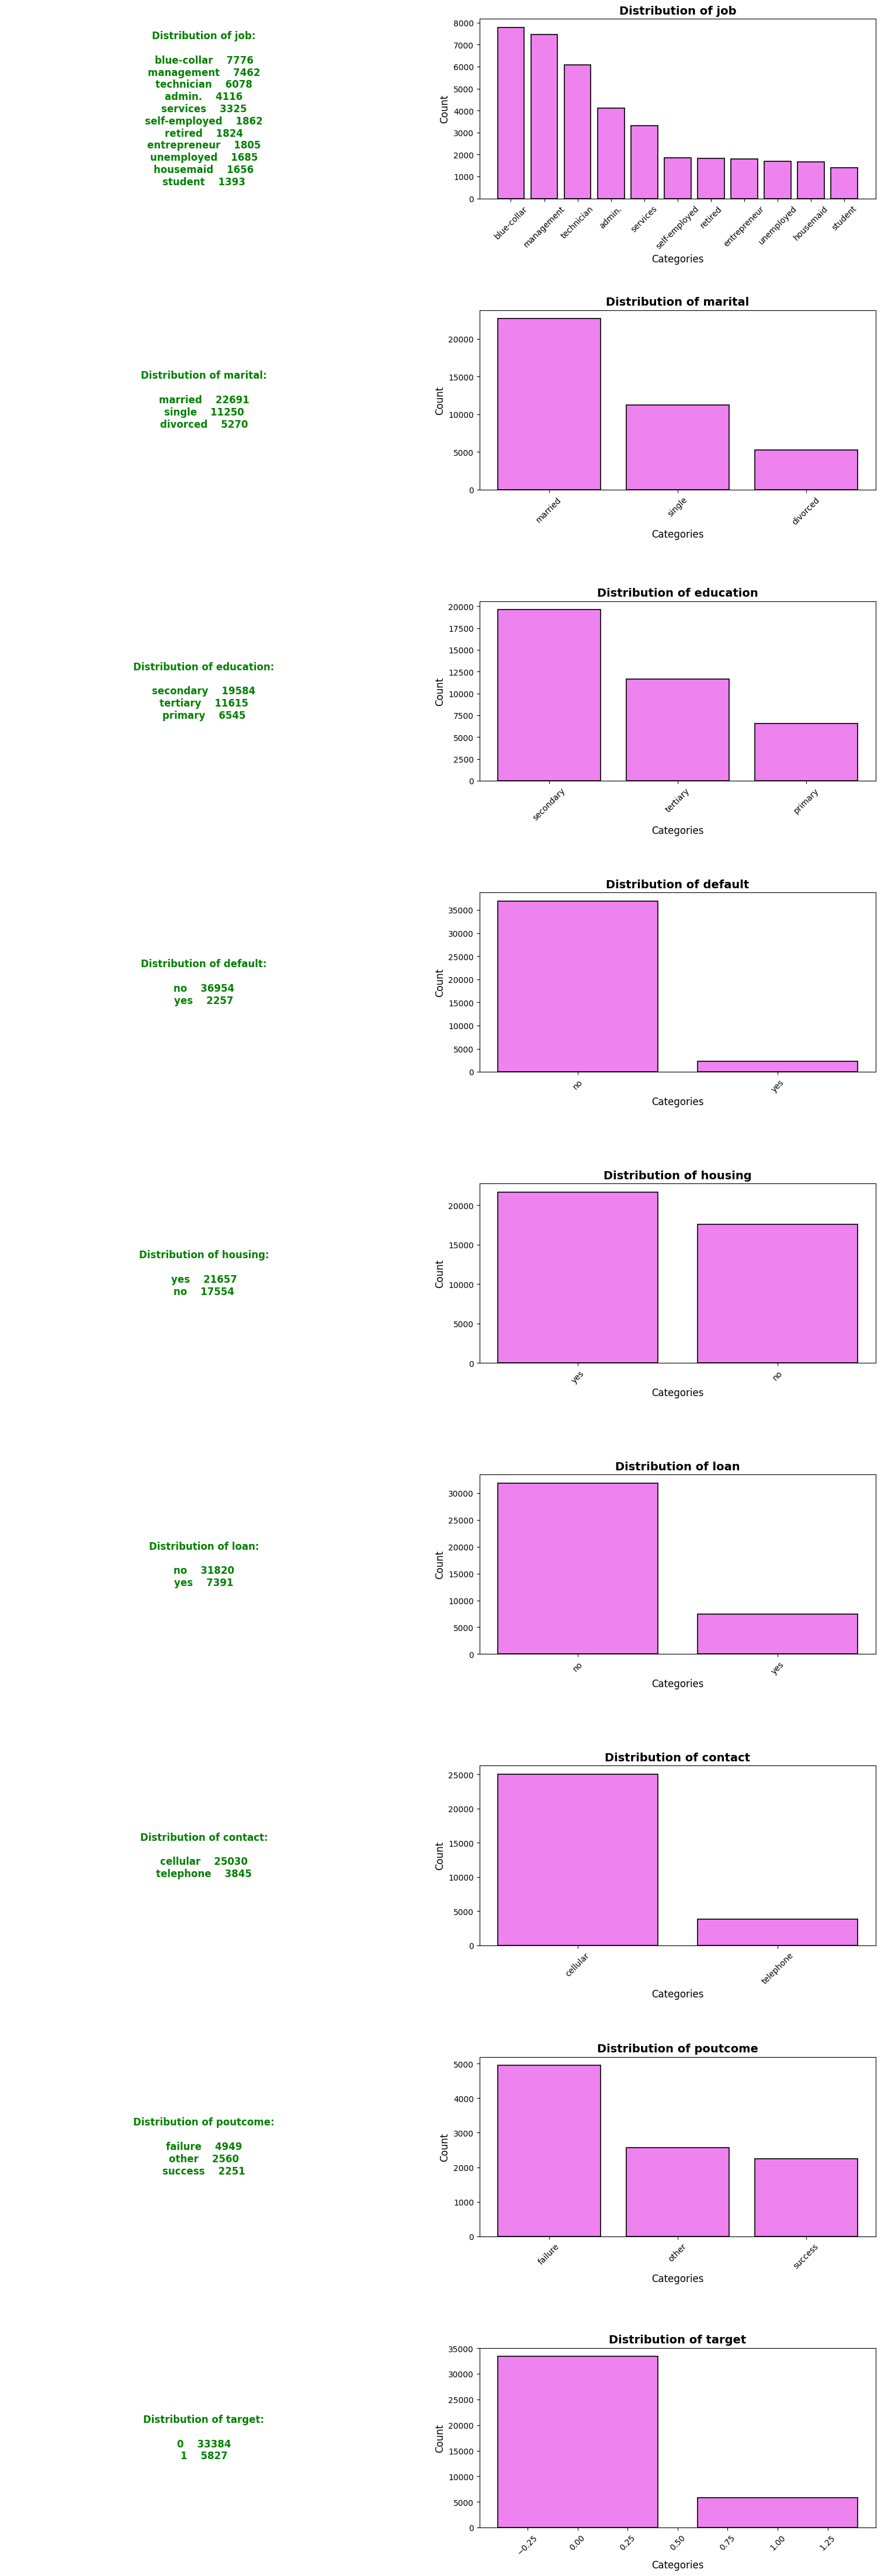

In [15]:
# Set number of columns for side-by-side layout
num_cols = 2

# Exclude 'last contact date' from the cat features
cat = [feature for feature in cat if feature != "last contact date"]

# Create a figure with two columns
num_rows = len(cat)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))

# Ensure that axes is a 2D array, even if it's a single row
axes = axes if num_rows > 1 else [axes]

# Loop through the categorical features & plot it
for i, feature in enumerate(cat):
    axes[i][0].axis('off')
    value_counts = train[feature].value_counts()
    value_counts_str = "\n".join([f"{category}    {count}" for category, count in value_counts.items()])
    axes[i][0].text(0.5, 0.5, f"Distribution of {feature}:\n\n{value_counts_str}",
                    ha='center', va='center', fontsize=12, fontweight='bold', color='green')

    axes[i][1].bar(value_counts.index, value_counts.values,
                   color='violet', edgecolor='black', linewidth=1.2)
    axes[i][1].set_title(f'Distribution of {feature}', fontsize=14, fontweight='bold')
    axes[i][1].set_xlabel('Categories', fontsize=12)
    axes[i][1].set_ylabel('Count', fontsize=12)
    axes[i][1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i][1].tick_params(axis='y', labelsize=10)
    # axes[i][1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.show()

**1. Contact Type**:
- Cellular is the preferred communication medium, aligning with modern trends and suggesting better engagement potential.
  
**2. Education**:
- Education level might influence decision-making, with secondary-educated clients forming the largest group.
  
**3. Marital Status**:
- Married individuals may be the primary target group, but understanding their financial flexibility will be crucial.
  
**4. Job Type**:
- Occupation could reflect financial stability and influence subscription rates.
  
**5. Loan and Housing**:
- Loan-free clients might be more likely to subscribe due to greater financial flexibility.
  
**6. Previous Campaign Outcomes**:
- This indicates potential inefficiencies in past campaigns and opportunities for better targeting in future efforts.

**Last contact date**

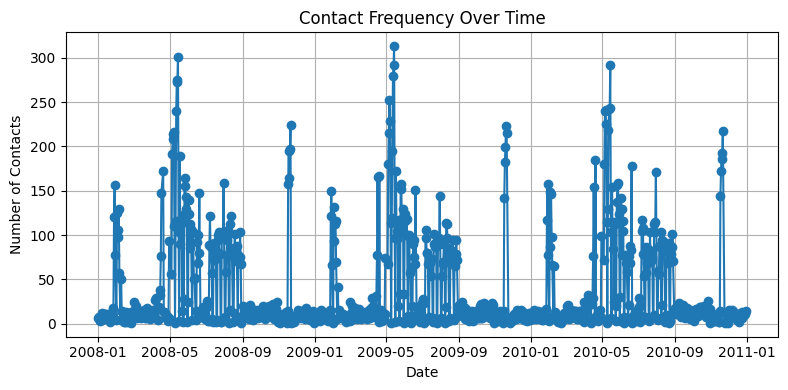

In [16]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
count = train['last contact date'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
plt.plot(count.index, count.values, marker='o', linestyle='-')
plt.title('Contact Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Contacts')
plt.grid(True)
plt.tight_layout()
plt.show()

**Numerical Features**

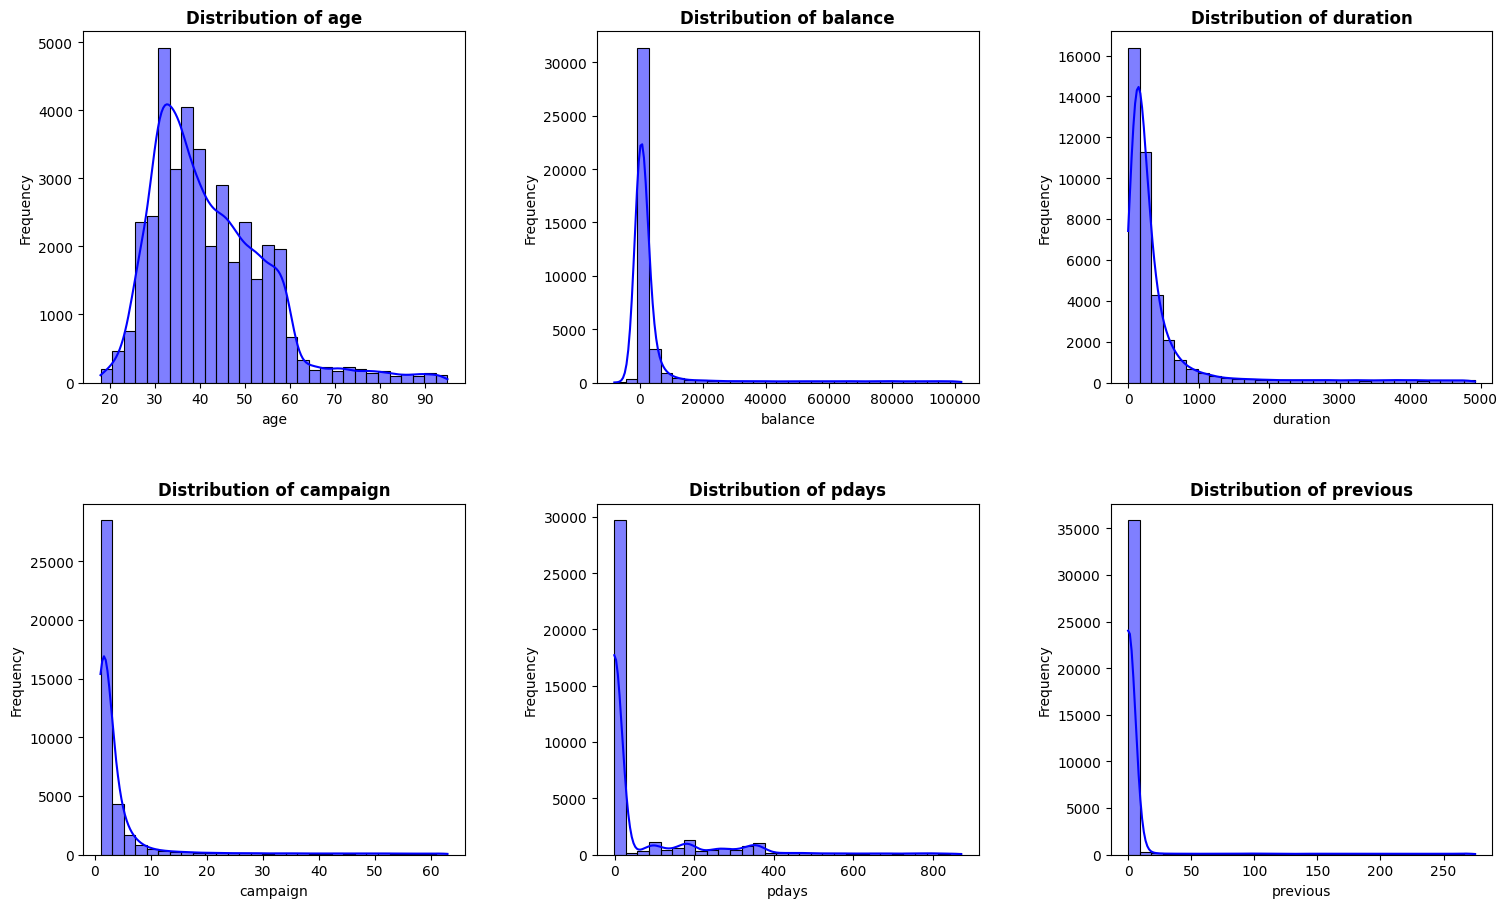

In [17]:
# Set the number of columns per row
num_cols = 3

# Number of rows based on the number of numeric features
num_rows = len(num) // num_cols + (1 if len(num) % num_cols != 0 else 0)

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))

# Flatten axes array if the number of rows is 1
axes = axes.flatten()

# Loop through each numeric feature and plot it
for i, feature in enumerate(num):
    sns.histplot(train[feature], kde=True, bins=30, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

# Remove extra subplots if the number of features is not divisible by num_cols
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=4.0)
plt.show()

1. **Age Distribution**:

- Insight: Most clients are aged between 30 and 50, with a peak around 35. The distribution is slightly **right-skewed**, with fewer clients over 60.
- Recommendation: Focus marketing efforts on the 30-50 age group for better conversion.

2. **Balance Distribution**:

- Insight: Most clients have low balances, with many clustered near zero. The distribution is **positively skewed**, with a few outliers having high balances.
- Recommendation: Segment clients into **low, medium, & high-balance groups** for tailored campaigns. Create premium campaigns for high-balance clients to maximize returns.
  
3. **Duration of Last Contact**:

- Insight: Most calls are **shorter than 300 seconds**, but longer calls are associated with **higher subscription rates**.
- Recommendation: Encourage agents to focus on **engaging longer conversations** with interested clients to improve conversions.

4. **Number of Contacts in Current Campaign (Campaign)**:

- Insight: Most clients were contacted only **once or twice** and excessive contacts lead to **diminishing returns**.
- Recommendation: **Optimize contact frequency** to avoid over-contacting clients while maintaining engagement.

5. **Days Since Last Contact (Pdays)**:

- Insight: Many clients have a **-1 value**, meaning no prior contact. For others, longer gaps between contacts are common.
- Recommendation: Prioritize **recently contacted clients** for follow-ups and develop strategies to **re-engage clients with longer gaps**.

6. **Previous Campaign Contacts (Previous)**:

- Insight: Most clients had **fewer than 5 previous contacts**, indicating limited engagement history.
- Recommendation: Focus on **meaningful contacts** from previous campaigns to replicate successful strategies.



### General Insights ##

- <u>Skewness</u>: Variables like **balance** and **duration** are highly skewed, which may require **log transformations** or other techniques for better modeling.
  
- <u>Outliers</u>: Extreme values in **balance** and **duration** may distort analysis. Consider **handling outliers** to avoid their undue influence.
  
- <u>Binning</u>: Grouping features like **age** and **balance** into categories can simplify analysis and improve segmentation.

## 5. Bivariate and Multivariate Analysis ##

**Correlation Between Numerical Features**

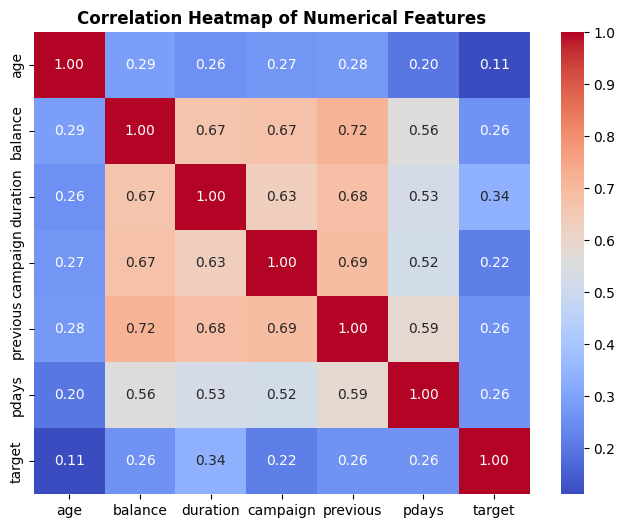

In [18]:
num = ['age', 'balance', 'duration', 'campaign', 'previous', 'pdays', 'target']

plt.figure(figsize=(8, 6))
correlation = train[num].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features', fontsize=12, fontweight='bold')
plt.show()

- "target" has the highest correlation with "duration" (~0.34), suggesting duration may have some predictive power for the target.

**Relationships**

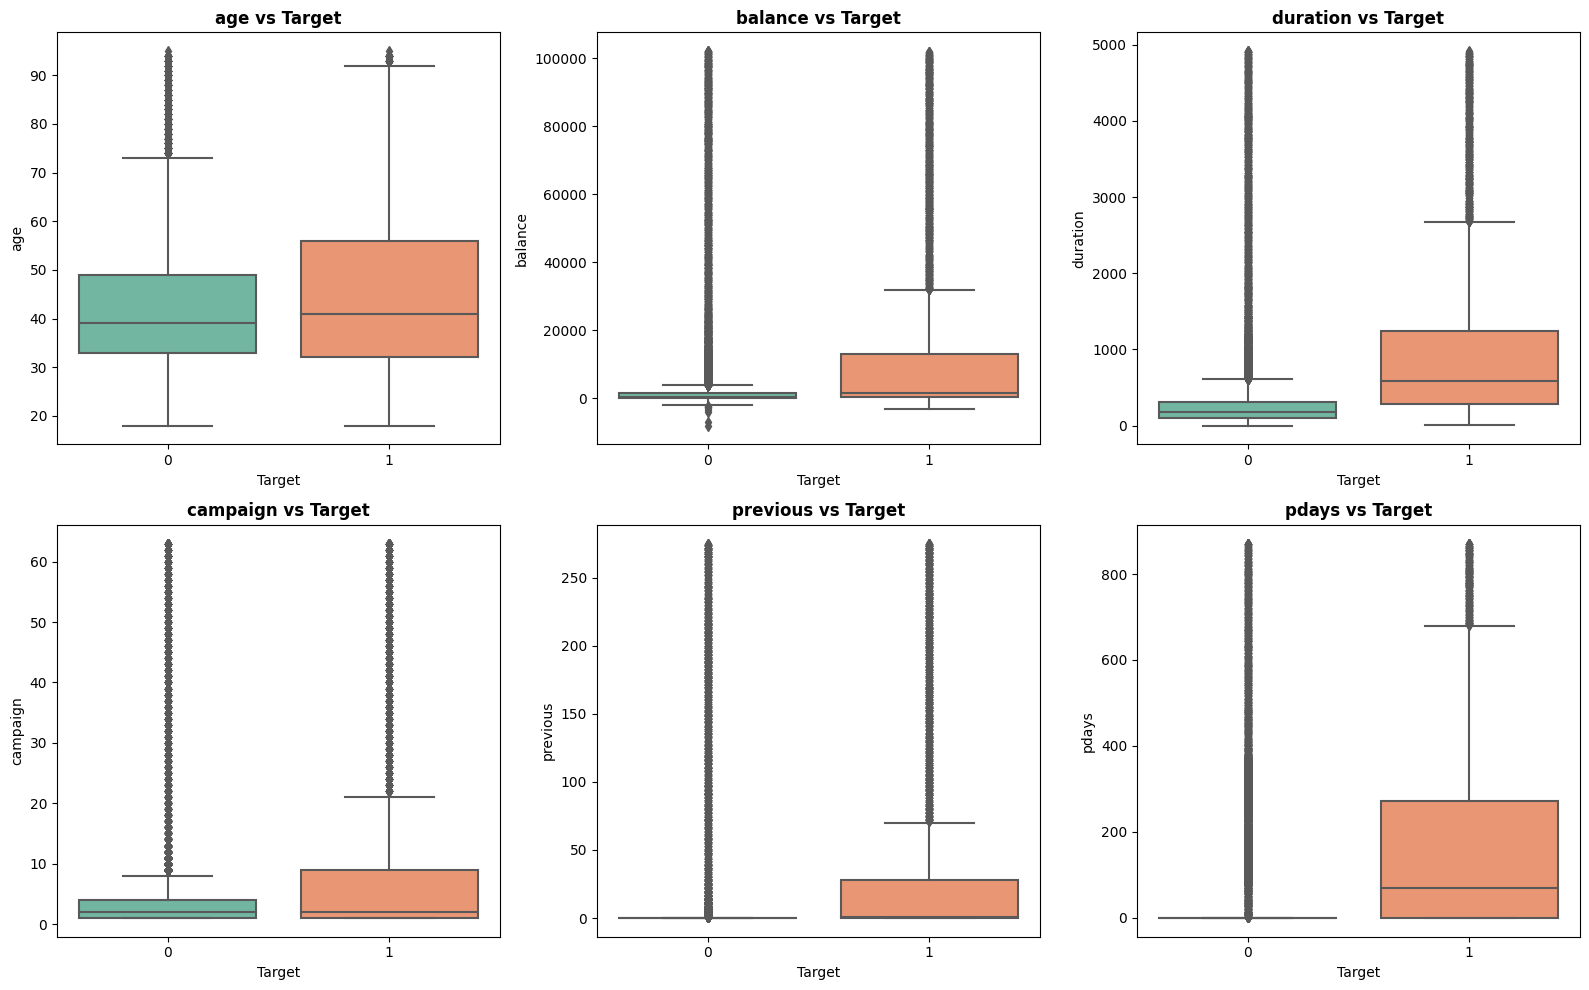

In [19]:
num = ['age', 'balance', 'duration', 'campaign', 'previous', 'pdays']

# Number of columns per row
num_cols = 3
num_rows = (len(num) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))
axes = axes.flatten()

# Loop through numerical features and plot boxplots
for i, feature in enumerate(num):
    sns.boxplot(x=train['target'], y=train[feature], palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feature} vs Target', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

# Hide any unused axes
for i in range(len(num), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**1. Age vs Target**:
- Both groups have similar age ranges. However, there is slightly more variation (spread) in the age of individuals with Target=1. This suggests that age might <u>not be a strong predictor</u> of the target variable.
  
**2. Balance vs Target**:
- Individuals with Target=1 have higher account balances compared to Target=0. This indicates that people with <u>higher balances might be more likely to belong to the Target=1</u> group.
  
**3. Duration vs Target**:
- People with Target=1 tend to have much higher durations compared to Target=0. This is a <u>strong signal that higher durations are associated with Target=1</u>.
  
**4. Campaign vs Target**:
- The distribution of campaigns is similar for both groups. Most individuals are in the lower campaign count, so this feature might <u>not strongly distinguish</u> between Target=0 and Target=1.
  
**5. Previous vs Target**:
- For Target=1, the number of previous contacts is generally higher than for Target=0. This suggests that <u>having more previous contacts is somewhat related to belonging to Target=1</u>.
  
**6. Pdays vs Target**:
- For Target=1, the number of days since the last campaign is significantly higher compared to Target=0. This could mean that <u>individuals contacted after a longer gap are more likely to fall into the Target=1</u> group.


**Simplified Key Takeaways**:
- <u>Important Features</u>: Duration, Balance, and Pdays seem to have the most significant differences between Target=0 and Target=1. These features could be critical for predicting the target variable.
  
- <u>Less Important Features</u>: Age and Campaign have overlapping distributions and may not be as helpful for distinguishing the target groups.

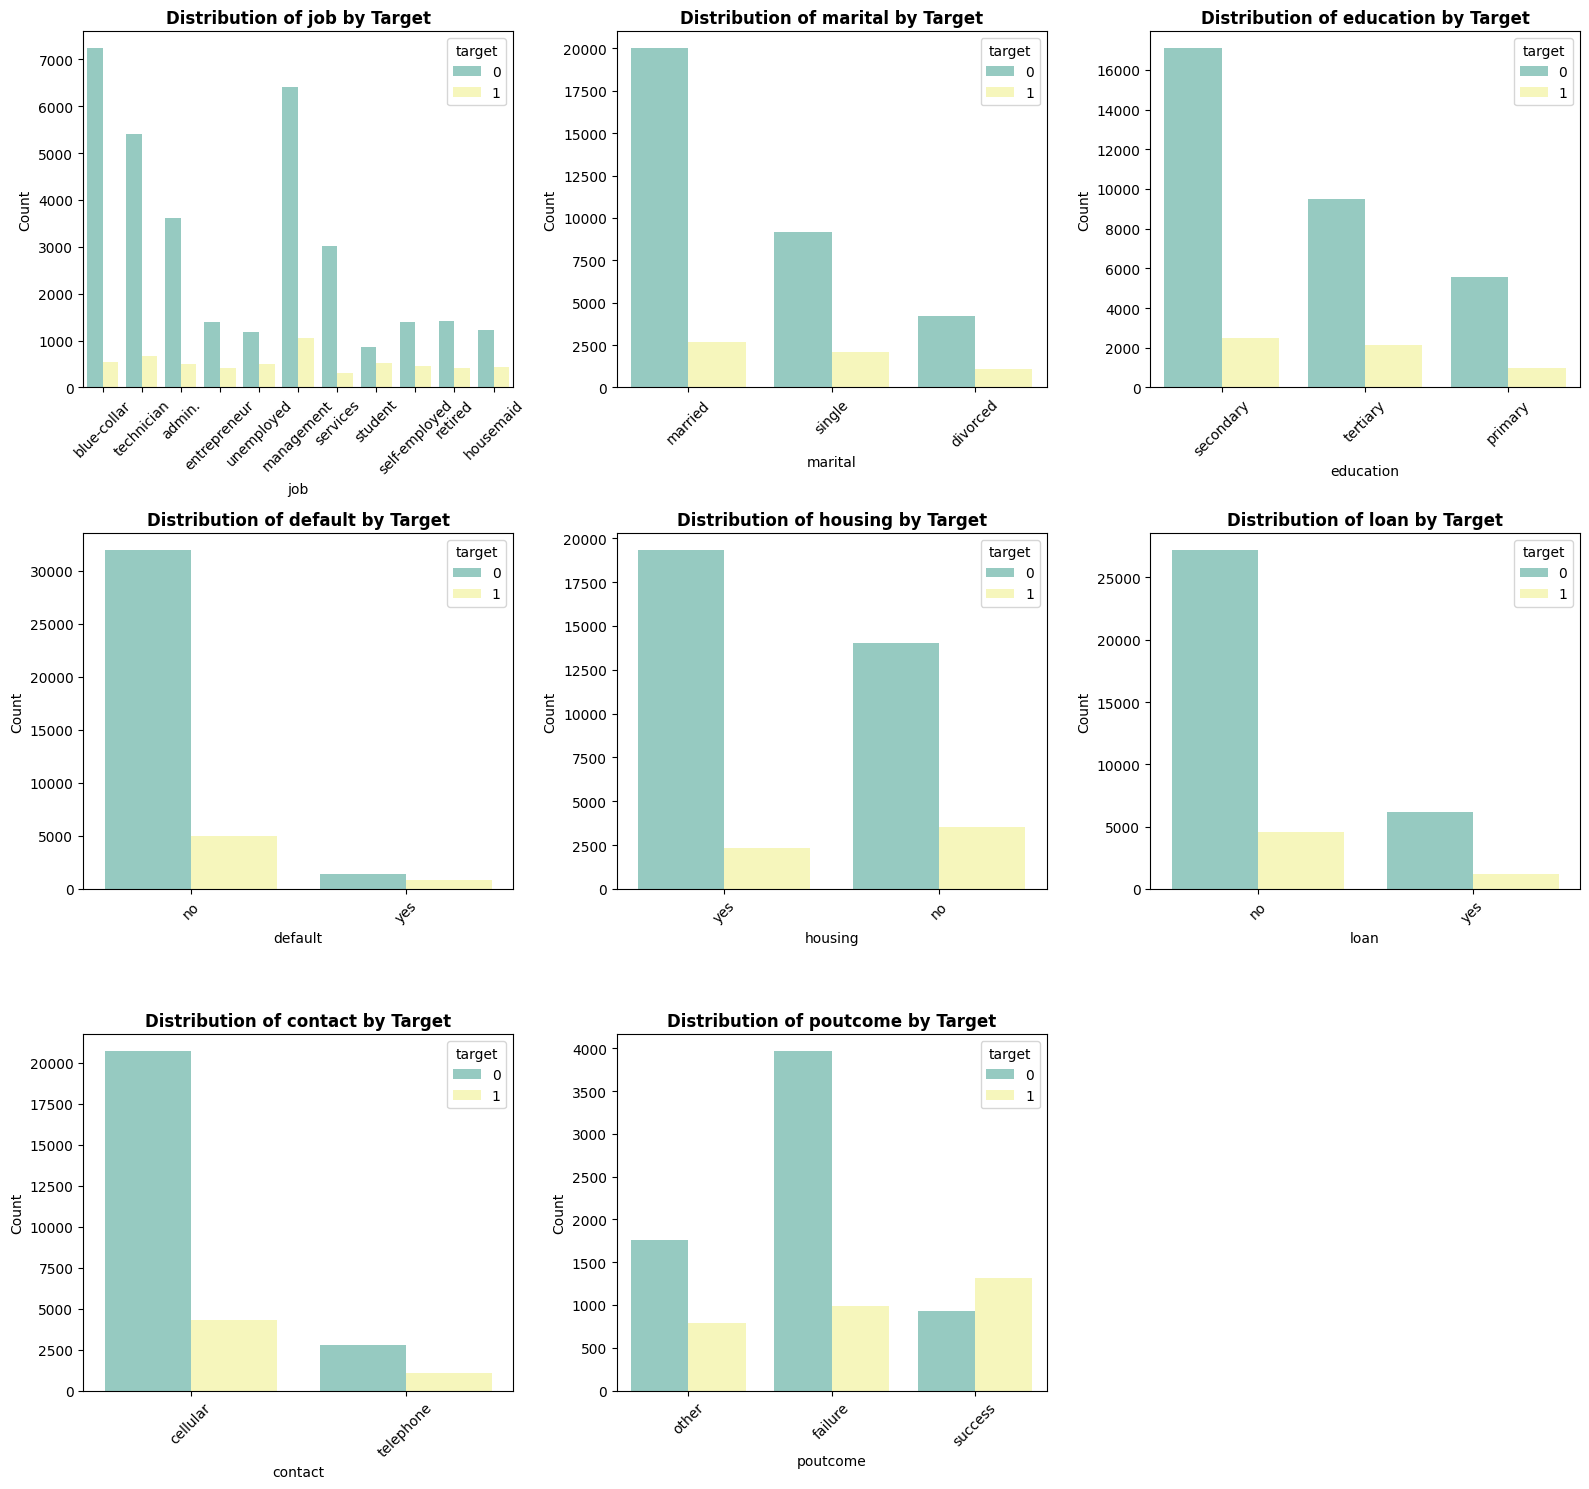

In [20]:
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Number of columns per row
num_cols = 3
num_rows = (len(cat) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))
axes = axes.flatten()

# Loop through categorical features and plot count plots
for i, feature in enumerate(cat):
    sns.countplot(x=train[feature], hue=train['target'], palette='Set3', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused axes
for i in range(len(cat), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**1. Job vs Target**:
- People with blue-collar jobs are more likely in Target=0.
- People with management and technician jobs have a relatively higher proportion in Target=1.
  
**2. Marital vs Target**:
- Married individuals are mostly in Target=0.
- Singles are more likely to belong to Target=1.
  
**3. Education vs Target**:
- People with secondary education are predominant in both groups.
- Individuals with tertiary education have a relatively higher proportion in Target=1.
  
**4. Default vs Target**:
- Most individuals do not have a default (no) in both groups.
- Very few individuals with defaults (yes) belong to Target=1.
  
**5. Housing vs Target**:
- People with housing loans (yes) are more likely in Target=0.
- Those without housing loans (no) have a relatively higher proportion in Target=1.
  
**6. Loan vs Target**:
- Most individuals do not have a loan (no), and they dominate both Target=0 and Target=1.
- Individuals with loans (yes) are less likely to belong to Target=1.
  
**7. Contact vs Target**:
- People contacted via cellular methods have a higher proportion in Target=1.
- Those contacted via telephone are more likely to belong to Target=0.
  
**8. Poutcome vs Target**:
- A successful (success) outcome is highly correlated with Target=1.
- Other outcomes (failure, unknown) are more dominant in Target=0.


**Simplified Takeaways**:
- <u>Features with Strong Signals</u>:
  - Poutcome: A "successful" previous outcome is a strong indicator of Target=1.
  - Contact: Cellular contact is linked to Target=1.
  - Housing Loan: Those without housing loans are more likely to belong to Target=1.

- <u>Features with Weak Signals</u>:
  - Default: Very few individuals have a default, so it may not significantly contribute to predictions.

## 6. Feature Engineering ##

**Creating New Features**

**Extraction of column last contact date**:

"This helps analyze temporal patterns, like which months or weekdays are more effective for marketing."

In [21]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
test['last contact date'] = pd.to_datetime(test['last contact date'])

train['month'] = train['last contact date'].dt.month
train['weekday'] = train['last contact date'].dt.weekday

test['month'] = test['last contact date'].dt.month
test['weekday'] = test['last contact date'].dt.weekday

train.drop(columns=['last contact date'],inplace=True)
test.drop(columns=['last contact date'],inplace=True)

**Binning of column Age**
- To capture the non-linear relationships b/w different age group.
- Helps to reduce the impact of outliers.

In [22]:
bins = [0, 20, 35, 50, 65, 100]
labels = [1, 2, 3, 4, 5]         

train['age_bin'] = pd.cut(train['age'], bins=bins, labels=labels)
test['age_bin'] = pd.cut(test['age'], bins=bins, labels=labels)

train = train.drop(['age'], axis=1)
test = test.drop(['age'], axis=1)

## 7. Preprocessing ##

In [23]:
print(train.poutcome.isna().sum())
print(train.contact.isna().sum())

print((train["pdays"]<0).sum())

29451
10336
29446


- "poutcome" & "contact" contains a large number of null values
- "pdays" contains large number of negative values

**Dropping columns**

In [24]:
train.drop(['poutcome', 'contact', 'pdays'], axis=1, inplace=True)
test.drop(['poutcome', 'contact', 'pdays'], axis=1, inplace=True)

In [25]:
X = train.drop(columns=["target"])
y = train["target"]

**Encoding Target Variable for binary classification**

In [26]:
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
y = pd.DataFrame(y,columns=["target"])

**Splitting dataset into training & validation set**

**Note:**

- Using **stratify=y**, so that our training data & validation data is splitting in the same proportion of our target variable, so that the skewness can be maintained.

In [27]:
x_train,x_val,y_train,y_val = train_test_split(X, y, train_size = 0.8, random_state = 0, stratify = y)

**Define categorical_cols & numerical_cols**

In [28]:
categorical_cols = ['age_bin','job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'weekday']
numerical_cols = ['balance', 'duration', 'campaign', 'previous']

**Data PreProcessing Pipeline**

- Categorical Features:
  - Missing values handled using SimpleImputer with a constant value ('unknown').
  - Categorical features encoded using OneHotEncoder, ensuring the model could interpret them.
- Numerical Features:
  - Missing values were imputed using the column mean.
  - Standard scaling applied to standardize numerical features.

In [29]:
# Define Transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),        
    ('scaler', StandardScaler())                        
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      
])

# Combine Numerical and Categorical Transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the Full Pipeline
pipeline_ = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and Transform Data
x_train_transformed = pipeline_.fit_transform(x_train)
x_val_transformed = pipeline_.transform(x_val)
test_transformed = pipeline_.transform(test)

# Extract Feature Names
num_features = numerical_cols
cat_features = pipeline_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine Feature Names
all_features = list(num_features) + list(cat_features)

# Convert Sparse Matrices to Dense DataFrames
x_train_transformed = pd.DataFrame(x_train_transformed.toarray(), columns=all_features, index=x_train.index)
x_val_transformed = pd.DataFrame(x_val_transformed.toarray(), columns=all_features, index=x_val.index)
test = pd.DataFrame(test_transformed.toarray(), columns=all_features, index=test.index)

**Dimensionality Reduction using PCA**
- helps in reducing ovefitting & improving model performance by removing less informative features
- making the data smaller & more manageable

In [30]:
pca = PCA(n_components = 0.98)

x_train_reduced_pca = pca.fit_transform(x_train_transformed)
x_val_reduced_pca = pca.transform(x_val_transformed)
test_reduced_pca = pca.transform(test)

x_train_pca = pd.DataFrame(x_train_reduced_pca)
x_val_pca = pd.DataFrame(x_val_reduced_pca)
test_pca = pd.DataFrame(test_reduced_pca)

## 8. Model Training & Evaluation ##

**1. Logistic Regression**
- used for binary classification problems
- handles imbalanced data well

In [31]:
model_1 = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 0)
model_1.fit(x_train_transformed, y_train)

y_pred = model_1.predict(x_val_transformed)
report = classification_report(y_val, y_pred)

print(report)
print(roc_auc_score(y_val, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.84      0.88      6677
           1       0.42      0.68      0.52      1166

    accuracy                           0.81      7843
   macro avg       0.68      0.76      0.70      7843
weighted avg       0.86      0.81      0.83      7843

0.7567466182134672


In [32]:
model_1 = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 0)
model_1.fit(x_train_pca, y_train)

y_pred = model_1.predict(x_val_pca)
report = classification_report(y_val, y_pred)

print(report)
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6677
           1       0.38      0.68      0.49      1166

    accuracy                           0.79      7843
   macro avg       0.66      0.74      0.68      7843
weighted avg       0.85      0.79      0.81      7843

0.7446493312723769


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**2. XGB Classifier**
- handles class imbalance better
- robust to missing data

In [33]:
model_2 = XGBClassifier(scale_pos_weight=2, random_state=42)
model_2.fit(x_train_transformed, y_train)

y_pred = model_2.predict(x_val_transformed)
report = classification_report(y_val, y_pred)

print(report)
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      6677
           1       0.52      0.62      0.57      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.76      0.74      7843
weighted avg       0.87      0.86      0.86      7843

0.7613526863550176


In [34]:
model_2 = XGBClassifier(scale_pos_weight=2, random_state=42)
model_2.fit(x_train_pca, y_train)

y_pred = model_2.predict(x_val_pca)
report = classification_report(y_val, y_pred)

print(report)
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6677
           1       0.49      0.52      0.50      1166

    accuracy                           0.85      7843
   macro avg       0.70      0.71      0.71      7843
weighted avg       0.85      0.85      0.85      7843

0.7116580149824376


**3. LightGBM Classifier**
- used for both classification and regression problems
- best for large datasets, imbalanced classes

In [35]:
model_3 = LGBMClassifier(random_state=42, is_unbalance=True)
model_3.fit(x_train_transformed, y_train)

y_pred = model_3.predict(x_val_transformed)
report = classification_report(y_val, y_pred)

print(report)
print(roc_auc_score(y_val, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

           0       0.97      0.81      0.89      6677
           1       0.45      0.86      0.59      1166

    accuracy                           0.82      7843
   macro avg       0.71      0.84      0.74      7843
weighted avg       0.89      0.82      0.84      7843

0.8362599291852345


In [36]:
model_3 = LGBMClassifier(random_state = 42, is_unbalance=True)
model_3.fit(x_train_pca, y_train)

y_pred = model_3.predict(x_val_pca)
report = classification_report(y_val, y_pred)

print(report)
print(roc_auc_score(y_val, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      6677
           1       0.42      0.81      0.56      1166

    accuracy                           0.81      7843
   macro avg       0.69      0.81      0.72      7843
weighted avg       0.88      0.81      0.83      7843

0.8082773587731469


"During the evaluation process, i observed that using x_val_transformed provided a higher macro F1-score compared to x_val_pca. This indicated that the transformed features retained more predictive power than the dimensionality-reduced PCA features.

**Based on this observation, i decided to use "x_val_transformed" for model comparison and hyperparameter tuning to ensure that the models leveraged the full feature set, ultimately leading to better performance.**"

**Comparison of Models**

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696


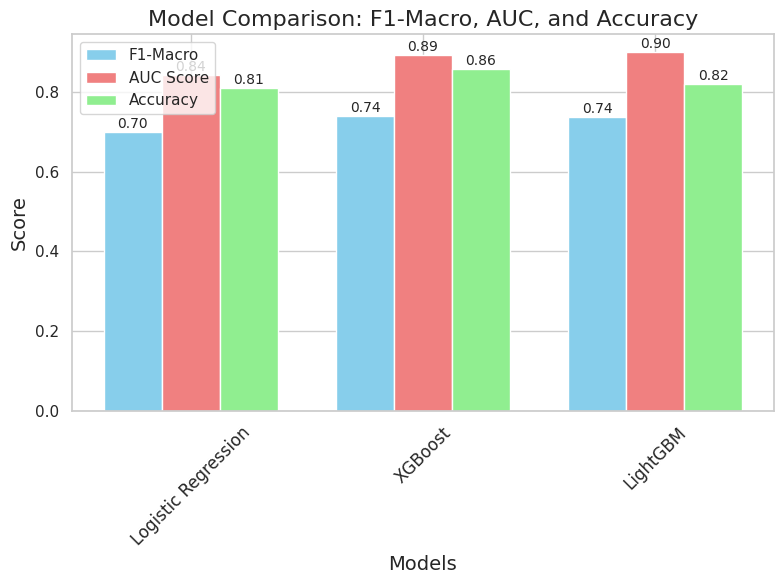

In [37]:
# Define models
model_1 = LogisticRegression(class_weight='balanced',max_iter=1000, random_state=0)
model_2 = XGBClassifier(scale_pos_weight=2, random_state=42)
model_3 = LGBMClassifier(random_state=42,is_unbalance=True)

# Model list and names
models = [model_1, model_2, model_3]
model_names = [
    'Logistic Regression',
    'XGBoost',
    'LightGBM'
]

# Initialize lists for metrics
f1_scores = []
auc_scores = []
accuracies = []

# Evaluate models
for model in models:
    # Fit model
    model.fit(x_train_transformed, y_train)

    # Predict class labels and probabilities
    y_pred = model.predict(x_val_transformed)
    y_proba = model.predict_proba(x_val_transformed)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='macro')
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else 0  

    # Append results
    f1_scores.append(f1)
    auc_scores.append(auc)
    accuracies.append(accuracy)

# Visualization
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

x = range(len(model_names))
width = 0.25

# Create grouped bar plots
ax.bar([i - width for i in x], f1_scores, width, label='F1-Macro', color='skyblue')
ax.bar(x, auc_scores, width, label='AUC Score', color='lightcoral')
ax.bar([i + width for i in x], accuracies, width, label='Accuracy', color='lightgreen')

# Add labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Model Comparison: F1-Macro, AUC, and Accuracy', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=12, rotation=45)
ax.legend(loc='best')

# Annotate bar heights
for i in x:
    ax.text(i - width, f1_scores[i] + 0.01, f'{f1_scores[i]:.2f}', ha='center', fontsize=10)
    ax.text(i, auc_scores[i] + 0.01, f'{auc_scores[i]:.2f}', ha='center', fontsize=10)
    ax.text(i + width, accuracies[i] + 0.01, f'{accuracies[i]:.2f}', ha='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

- **F1-Score**: especially useful when dealing with imbalanced datasets, where the classes are not represented equally.
    - <u>F1</u>: Balances precision and recall = {2*[(Precision * Recall)/(Precision + Recall)]}
    - <u>Precision</u>: Focuses on the correctness of positive predictions = TP/(TP+FP)
    - <u>Recall</u>: Focuses on the ability to identify all positive instances = TP/(TP+FN)
- **AUC Score**: Evaluates the model's ability to distinguish between classes.
- **Accuracy**: Evaluates the performance of a classification model. (TP+TN)/(TP+TN+FP+FN)

## 9. Hyper Parameter Tuning ##

**LogisticRegression Tuning**

In [38]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # Define hyperparameters to tune
# param_grid_logreg = {
#     'penalty': ['l1', 'l2', 'elasticnet'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga'],
#     'l1_ratio': [0.1, 0.5, 0.9]  # Only relevant when penalty='elasticnet'
# }

# # Initialize Logistic Regression model
# logreg = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

# # Initialize GridSearchCV
# lg_gscv = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, scoring='f1_macro', cv=5, n_jobs=-1, verbose=3)

# # Fit GridSearchCV
# lg_gscv.fit(x_train_transformed, y_train)

# # Best parameters found
# print(f"Best Parameters for Logistic Regression: {lg_gscv.best_params_}")

# # Get best model and make predictions
# best_logreg = lg_gscv.best_estimator_
# y_pred_logreg = best_logreg.predict(x_val_transformed)
# y_proba_logreg = best_logreg.predict_proba(x_val_transformed)[:, 1]

# # Print classification report and AUC score
# print(classification_report(y_val, y_pred_logreg))
# print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_logreg):.3f}")

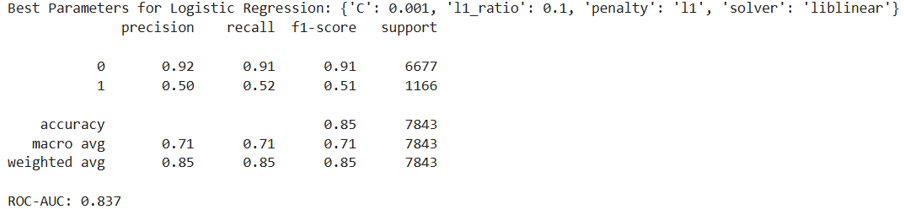

**Prameters**
- penalty: The type of regularization ('l1', 'l2', or 'elasticnet')
- C: The regularization strength (smaller values mean stronger regularization)
- solver: Optimization algorithm ('liblinear' or 'saga')
- l1_ratio: The elastic net mixing parameter (only used if penalty='elasticnet')

**XGBClassifier Tuning**

In [39]:
# from xgboost import XGBClassifier

# # Define hyperparameters to tune
# param_grid_xgb = {
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2],        
#     'n_estimators': [50, 100, 150],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'scale_pos_weight': [1, 2, 5]
# }

# # Initialize XGBClassifier
# xgb = XGBClassifier(random_state=42, scale_pos_weight=2)

# # Initialize GridSearchCV
# xgb_gscv = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring='f1_macro', cv=5, n_jobs=-1, verbose=3)

# # Fit GridSearchCV
# xgb_gscv.fit(x_train_transformed, y_train)

# # Best parameters found
# print(f"Best Parameters for XGBoost: {xgb_gscv.best_params_}")

# # Get best model and make predictions
# best_xgb = xgb_gscv.best_estimator_
# y_pred_xgb = best_xgb.predict(x_val_transformed)
# y_proba_xgb = best_xgb.predict_proba(x_val_transformed)[:, 1]

# # Print classification report and AUC score
# print(classification_report(y_val, y_pred_xgb))
# print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_xgb):.3f}")

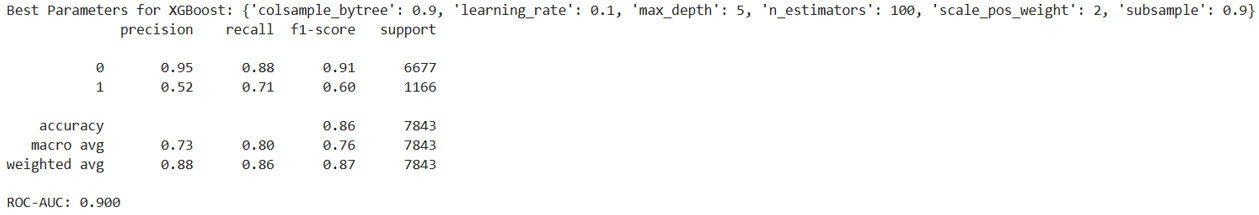

**Parameters**
- max_depth: Maximum depth of a tree.
- learning_rate: Step size shrinking to prevent overfitting.
- n_estimators: Number of boosting rounds (trees).
- subsample: Fraction of samples used to build each tree.
- colsample_bytree: Fraction of features used to build each tree.
- scale_pos_weight: Controls the balance of positive and negative weights.

**LGBMClassifier Tuning**

In [40]:
# from lightgbm import LGBMClassifier

# # Define hyperparameters to tune
# param_grid_lgbm = {
#     'max_depth': [-1, 50, 100],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 150],
#     'num_leaves': [31, 50, 100],
#     'min_child_samples': [10, 20, 50],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# # Initialize LGBMClassifier
# lgbm = LGBMClassifier(random_state=42, is_unbalance=True)

# # Initialize GridSearchCV
# lgbm_gscv = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, scoring='f1_macro', cv=3, n_jobs=-1, verbose=3)

# # Fit GridSearchCV
# lgbm_gscv.fit(x_train_transformed, y_train)

# # Best parameters found
# print(f"Best Parameters for LightGBM: {lgbm_gscv.best_params_}")

# # Get best model and make predictions
# best_lgbm = lgbm_gscv.best_estimator_
# y_pred_lgbm = best_lgbm.predict(x_val_transformed)
# y_proba_lgbm = best_lgbm.predict_proba(x_val_transformed)[:, 1]

# # Print classification report and AUC score
# print(classification_report(y_val, y_pred_lgbm))
# print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_lgbm):.3f}")

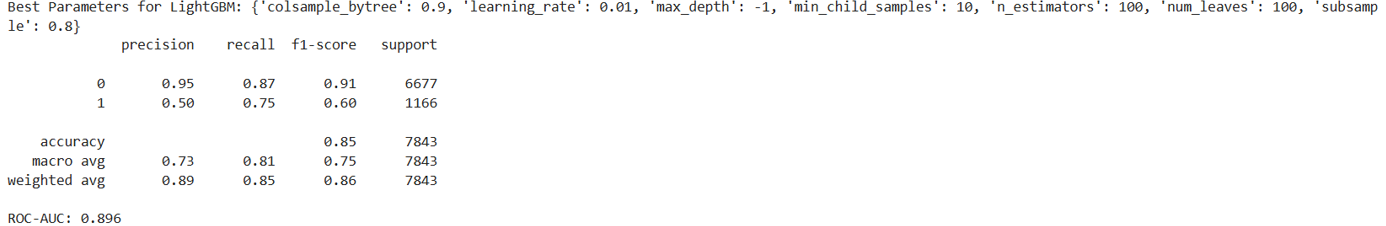

**Parameters**
- max_depth: Maximum depth of tree.
- learning_rate: Shrinking rate of tree.
- n_estimators: Number of trees.
- num_leaves: Number of leaves in one tree.
- min_child_samples: Minimum number of samples in one leaf.
- subsample: Fraction of samples used for training.
- colsample_bytree: Fraction of features used to build each tree.

## 10. Prediction ##

**Best Model**

In [41]:
# # Define the models (already trained as model_1, model_2, model_3)
# models = [model_1, model_2, model_3]
# model_names = ['Logistic Regression', 'XGBoost', 'LightGBM']

# # Initialize a list to store F1 scores
# f1_scores = []

# # Evaluate models on the validation set (you already have x_val and y_val)
# for model in models:
#     y_pred = model.predict(x_val_transformed)  # Predicting on the validation set
#     f1 = f1_score(y_val, y_pred, average='macro')  # Calculate F1-score (macro average)
#     f1_scores.append(f1)

# # Find the best model based on F1-score
# best_model_idx = f1_scores.index(max(f1_scores))  # Get the index of the best model
# best_model = models[best_model_idx]  # Get the best model based on index

# # Print the best model and its F1-score
# print(f"Best Model: {model_names[best_model_idx]}")
# print(f"Best F1-Score (Macro): {f1_scores[best_model_idx]:.4f}")

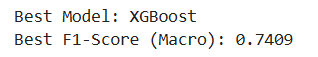

**Test prediction based on best model (best_params_) observed from hypertuning of 3 models**

In [42]:
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'scale_pos_weight': 2
}

final_model = XGBClassifier(**params)
final_model.fit(x_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
y_pred = final_model.predict(test)

In [44]:
submission = pd.DataFrame({"id":range(0,test.shape[0]), "target": y_pred})
submission['target'] = submission['target'].map({0: 'no', 1: 'yes'}) 
submission.to_csv('submission.csv',index=False)

"**From the training of three models, i found that:**

- **XGBoost** performed best because it is robust to outliers and effectively captures complex non-linear interactions, which is critical since duration and balance are key predictors with outliers.
  
- **Logistic Regression** underperformed as it is more sensitive to outliers, which likely influenced the coefficients disproportionately.
  
- **LightGBM** performed comparably to XGBoost as it is also a tree-based algorithm that handles outliers effectively.

**Based on these results, i decided to proceed with XGBoost for test predictions, using the best hyperparameters obtained through tuning. This approach resulted in a macro F1-score of 0.76 on the test set.**"

## Overfitting vs Underfitting Analysis ##

In [45]:
# Prediction
y_train_pred = final_model.predict(x_train_transformed)
y_val_pred = final_model.predict(x_val_transformed)

# F1-score
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')

print(f"Training F1-Score (Macro): {train_f1_macro:.4f}")
print(f"Validation F1-Score (Macro): {val_f1_macro:.4f}")

Training F1-Score (Macro): 0.7852
Validation F1-Score (Macro): 0.7580


"Based on the results, the **training F1-score is 0.7852**, while the **validation F1-score is 0.7580**. The slight gap between these scores indicates **minor overfitting**, as the model performs slightly better on the training data compared to the validation data. 
However, the gap is small enough to suggest that the model generalizes reasonably well to unseen data. There is **no evidence of underfitting**, <u>as the training F1-score is sufficiently high</u>, indicating the model has learned patterns effectively."

"<u>To handle the minor overfitting observed</u>, can apply techniques such as **adding regularization** (increasing lambda and alpha), **reducing the model's complexity** (lowering max_depth or increasing min_child_weight), and **using early stopping** to prevent over-training. Additionally, can experiment with **reducing the learning rate** while **increasing the number of estimators** for more gradual learning. These adjustments would help to improve the model's generalization to unseen data."